General imports

In [552]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
import seaborn as sns
from joblib import Parallel, delayed
from multiprocessing import cpu_count

from statsmodels.tsa.statespace.sarimax import SARIMAX

Reading dataset

In [553]:
df = pd.read_csv('GlobalLandTemperaturesByCountry.csv')

Quick view to the data

In [554]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [555]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Cleaning data

In [556]:
from quickda.explore_data import *
from quickda.clean_data import *
from quickda.explore_numeric import *
from quickda.explore_categoric import *
from quickda.explore_numeric_categoric import *
from quickda.explore_time_series import *

df.dropna()
df = clean(df, method = "replaceval",       
                columns = [],     # [] to replace in all columns
                to_replace = "",  # value to be replaced
                value = np.nan)   # value to replaced with
df = clean(df, method = "fillmissing")  # It uses the interpolation method
df = clean(df, method = "dropmissing")
explore(df)

,dtypes,count,null_sum,null_pct,nunique,min,25%,50%,75%,max,mean,median,std,skew
AverageTemperature,float64,577462,0,0.0,71085,-37.658,10.354,21.271,25.777,38.842,17.399923,21.271,10.83239,-1.146609
AverageTemperatureUncertainty,float64,577462,0,0.0,8979,0.052,0.333,0.617,1.34,15.003,1.077051,0.617,1.218259,2.886287
Country,object,577462,0,0.0,243,Afghanistan,-,-,-,Åland,-,-,-,-
dt,object,577462,0,0.0,3239,1743-11-01,-,-,-,2013-09-01,-,-,-,-


Meses (de todos los años) vs. Temperatura promedio en esos meses

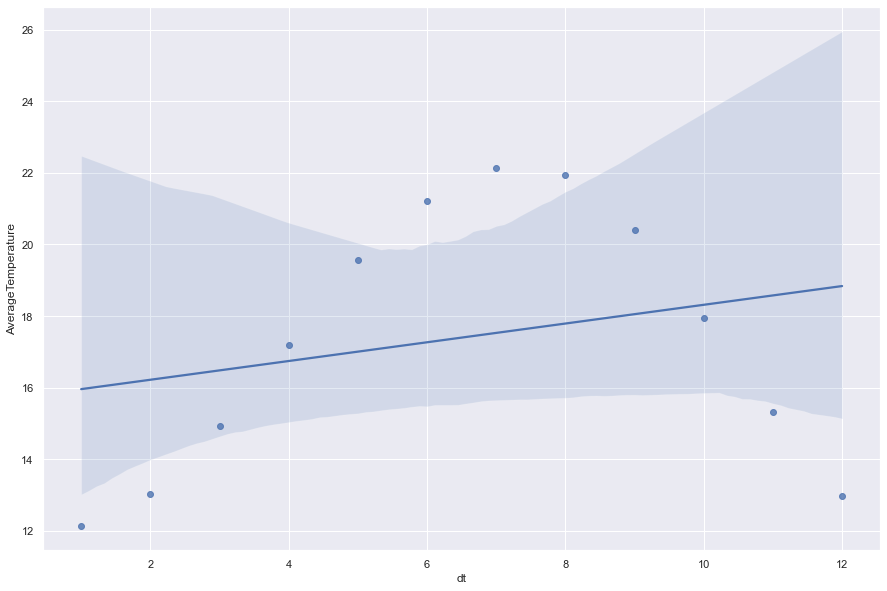

In [557]:
df['dt'] = pd.to_datetime(df['dt'])
monthlyDF = df.groupby(df['dt'].dt.strftime('%m'))['AverageTemperature'].mean().sort_values().reset_index(name='AverageTemperature')
# monthlyDF
monthlyDF = monthlyDF.sort_values('dt')
monthlyDF.rename(columns={0 : 'AverageTemperature'}, inplace=True)
monthlyDF['AverageTemperature'] = monthlyDF['AverageTemperature'].apply(lambda x: float(x))
monthlyDF['dt'] = monthlyDF['dt'].apply(lambda x: float(x))
sns.regplot(x=monthlyDF["dt"], y=monthlyDF["AverageTemperature"])
plt.show()

Comportamiento de la temperatura promedio en los últimos 20 años

In [558]:
df['dt'] = pd.to_datetime(df['dt'])
lastYearsDF = df[(df['dt'] > '1900-01-01')]
lastYearsDF = (lastYearsDF.groupby(df['dt'].dt.strftime('%Y'))['AverageTemperature'].mean().sort_values().reset_index(name='AverageTemperature'))
lastYearsDF = lastYearsDF.sort_values('dt')
lastYearsDF.rename(columns={0 : 'AverageTemperature'}, inplace=True)
lastYearsDF['AverageTemperature'] = lastYearsDF['AverageTemperature'].apply(lambda x: float(x))
lastYearsDF['dt'] = lastYearsDF['dt'].apply(lambda x: float(x))
lastYearsDF['type'] = 'lastYears'
lastYearsDF.head()
#plt.figure(figsize = (15,8))
#sns.lineplot(x=lastYearsDF["dt"], y=lastYearsDF["AverageTemperature"])

,dt,AverageTemperature,type
87,1900.0,19.035455,lastYears
19,1901.0,18.532834,lastYears
5,1902.0,18.339032,lastYears
11,1903.0,18.434771,lastYears
1,1904.0,18.211075,lastYears


In [559]:
last20YearsDF = df[(df['dt'] > '1995-06-01') & (df['dt'] < '2013-09-01')]
last20YearsDF = (last20YearsDF.groupby(df['dt'].dt.strftime('%Y'))['AverageTemperature'].mean().sort_values().reset_index(name='AverageTemperature'))
last20YearsDF = last20YearsDF.sort_values('dt')
last20YearsDF.rename(columns={0 : 'AverageTemperature'}, inplace=True)
last20YearsDF['AverageTemperature'] = last20YearsDF['AverageTemperature'].apply(lambda x: float(x))
last20YearsDF['dt'] = last20YearsDF['dt'].apply(lambda x: float(x))
last20YearsDF['type'] = 'last20Years'
last20YearsDF.head()

,dt,AverageTemperature,type
18,1995.0,20.096247,last20Years
0,1996.0,19.000665,last20Years
1,1997.0,19.291440,last20Years
14,1998.0,19.636447,last20Years
3,1999.0,19.432605,last20Years


In [560]:
lastYearsDF = pd.concat([lastYearsDF, last20YearsDF], ignore_index=True)
lastYearsDF.head()

,dt,AverageTemperature,type
0,1900.0,19.035455,lastYears
1,1901.0,18.532834,lastYears
2,1902.0,18.339032,lastYears
3,1903.0,18.434771,lastYears
4,1904.0,18.211075,lastYears


<AxesSubplot:xlabel='dt', ylabel='AverageTemperature'>

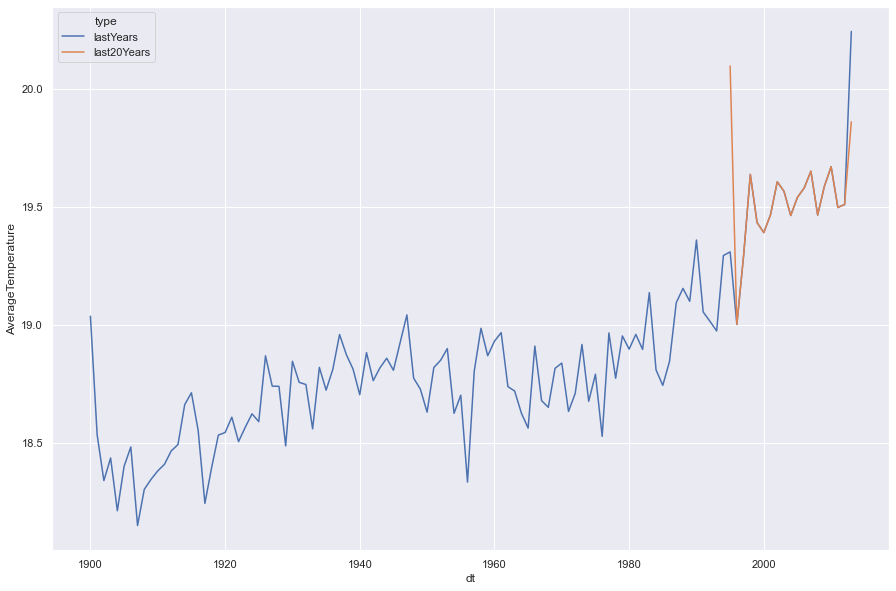

In [561]:
sns.lineplot(x=lastYearsDF["dt"], y=lastYearsDF["AverageTemperature"], hue=lastYearsDF["type"], markers=True)

Histograma de la temperatura promedio (Vista en el reporte)

<AxesSubplot:>

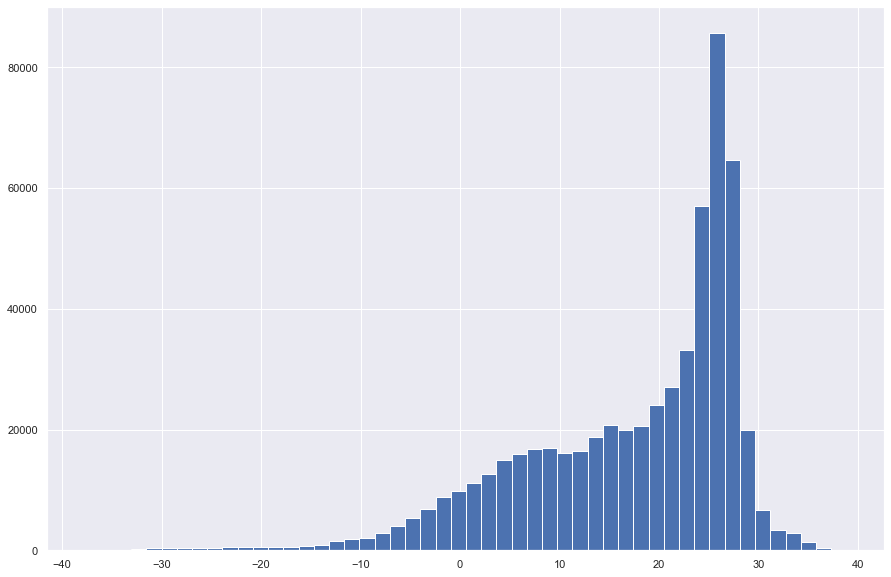

In [562]:
#2a.

df['AverageTemperature'].hist(bins=50)

Descomposición de la serie en sus componentes (Tendencia, estacional y aleatoria)

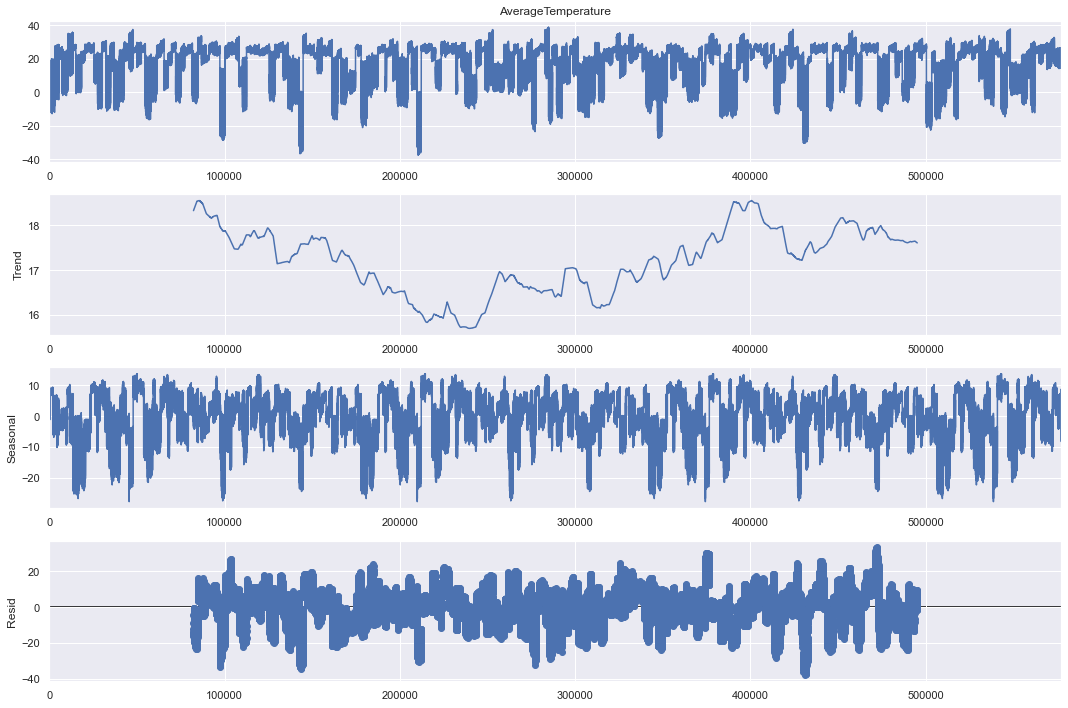

In [563]:
#2c

rcParams['figure.figsize'] = 15, 10

decomposition = sm.tsa.seasonal_decompose(df['AverageTemperature'],model='additive', period=164409)

fig = decomposition.plot()
plt.show()

Transformación de la serie

In [564]:
#2d 

# No es neecsario por la calidad de los datos

Modelo SARIMA

In [565]:
# #2e
# #2f

# def division_entreno_prueba(datos, n_prueba):
#     return datos[:-n_prueba], datos[-n_prueba:]

# def medir_rmse(actual, predicho):
#     return sqrt(mean_squared_error(actual, predicho))

# # validación "walk-forward" para datos univariados
# def validacion_al_frente(datos, n_prueba, metodo, cfg):
#     predicciones = []
#     # dividir el conjunto de datos
#     entreno, prueba = division_entreno_prueba(datos, n_prueba)
#     # grabar la historia con el conjunto de datos de entrenamiento
#     historia = [x for x in entreno]
#     # pasar por cada incremento de tiempo en el conjunto de prueba
#     for i in range(len(prueba)):
#         # ajustar el modelo a los datos y predecir los datos históricos
#         if metodo == "promedio":
#             yhat = prediccion_promedio(historia, cfg)
#         elif metodo == "sarima":
#             yhat = prediccion_sarima(historia, cfg)
#         elif metodo == "exp":
#             yhat = prediccion_alisamiento_exp(historia, cfg)
#         # agregar el dato predicho en la lista de preducciones
#         predicciones.append(yhat)
#         # agregar la observación a la historia para la siguiente iteración
#         historia.append(prueba[i])
#     # estimar el error de las predicciones
#     error = medir_rmse(prueba, predicciones)
#     return [error, predicciones]

# def busqueda_malla(datos, lista_cfg, n_prueba, metodo = "sarima", paralelo = True):
#     resultados = None
#     if paralelo:
#         # ejecutar las configuraciones en paralelo
#         executor = Parallel(n_jobs = cpu_count(), backend = 'multiprocessing') 
#         tareas = (delayed(calificar_modelo)(datos, n_prueba, metodo, cfg) for cfg in lista_cfg) 
#         resultados = executor(tareas)
#     else:
#         resultados = [calificar_modelo(datos, n_prueba, metodo, cfg) for cfg in lista_cfg]
#     # eliminar resultados vacíos
#     resultados = [r for r in resultados if r[1] != None]
#     return resultados

# def calificar_modelo(datos, n_prueba, metodo, cfg, debug = False):
#     resultado = None
#     predicciones = None
#     # convertir la confiuración a una llave
#     llave = str(cfg)
#     if debug:
#         resultado, predicciones = validacion_al_frente(datos, n_prueba, metodo, cfg)
#     else:
#         # una falla durante la validación del modelo sugiere una configuración inestable
#         try:
#         # nunca mostrar advertencias cuando se busca en malla...demasiado "ruido"
#             with catch_warnings():
#                 filterwarnings("ignore")
#                 resultado, predicciones = validacion_al_frente(datos, n_prueba, metodo, cfg)
#         except:
#             error = None
#     if resultado is not None:
#         print(f' > Modelo{llave} {resultado:.3f}')
#     return (llave, resultado, predicciones)

# def encontrar_mejor_solucion(series, nombre, metodo = "sarima", muestra = False):
#     datos = series.values
#     resultados = []
#     # dividir los datos
#     n_prueba = int(len(datos) * 0.2) # porcenta usado para prueba
#     long_max = len(datos) - n_prueba
#     print(f"Tamaño Entrenamiento {long_max}")
#     print(f"Tamaño Prueba {n_prueba}")

#     # configuraciones de los modelos
#     if metodo == "sarima":
#         print(f"Encontrando la mejor solución para {metodo}")
#         lista_cfg = config_sarima()
#     elif metodo == "promedio":
#         print(f"Encontrando la mejor solución para {metodo}")
#         lista_cfg = config_simple(long_max)
#     elif metodo == "exp":
#         print(f"Encontrando la mejor solución para {metodo}")
#         lista_cfg = config_alisamiento_exp()
#         datos = datos[:,0]
#     # muestrear algunos
#     if muestra:
#         lista_cfg_azar = random.sample(lista_cfg, k = 25)
#         while len(resultados) < 5:
#             lista_cfg_azar = random.sample(lista_cfg, k = 25)
#             resultados += busqueda_malla(datos, lista_cfg_azar, n_prueba, metodo)
#     else:
#         # búsqueda en malla

#         # Si se tiene capacidad de procesamiento paralelo, paralelo = True (default)
#         paralelo = True
#         resultados = busqueda_malla(datos, lista_cfg, n_prueba, metodo, paralelo)
        
    
#     # ordenan las configuraciones por error, ascendente
#     resultados.sort(key = lambda tup: tup[1])

#     print('terminado')
#     # listar las mejores 3 configuraciones
#     for cfg, error, predicciones in resultados[:3]:
#         print(cfg, error)

#     # desplegar
#     entreno, prueba = division_entreno_prueba(datos, n_prueba)
#     prediccion = pd.DataFrame(list(entreno.flatten()) + resultados[0][2])
#     ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales
#     prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))
#     # Esconder las líneas de malla de la gráfica
#     # ax.grid(False)

#     # Esconder las marcas en los ejes
#     #ax.set_xticks([])
#     #ax.set_yticks([])
    
#     plt.savefig(f"{nombre}_{metodo}.png", transparent = True)
#     plt.show()

# def prediccion_sarima(historia, config):
#     orden, orden_estacional, tendencia = config
#     # definir el modelo
#     modelo = SARIMAX(historia, order = orden, seasonal_order = orden_estacional, trend = tendencia,
#       enforce_stationarity = False, enforce_invertibility = False)
#     # ajustar el model con los datos
#     modelo_ajustado = modelo.fit(disp = False)
#     # hacer la predicción de un paso
#     yhat = modelo_ajustado.predict(len(historia), len(historia))
#     return yhat[0]

# def config_sarima(estacional = [0]):
#     modelos = []
#     # definir las listas de configuración
#     p_params = [0, 1, 2]
#     d_params = [0, 1]
#     q_params = [0, 1, 2]
#     t_params = ['n','c','t','ct'] 
#     P_params = [0, 1, 2]
#     D_params = [0, 1]
#     Q_params = [0, 1, 2]
#     m_params = estacional
#     # crear instancias de configuración
#     for p in p_params:
#         for d in d_params:
#             for q in q_params:
#                 for t in t_params:
#                     for P in P_params:
#                         for D in D_params:
#                             for Q in Q_params:
#                                 for m in m_params:
#                                     cfg = [(p,d,q), (P,D,Q,m), t]
#                                     modelos.append(cfg)
#     return modelos

In [566]:

sarimaDF = df[["dt", "AverageTemperature"]]
sarimaDF = sarimaDF[(sarimaDF['dt'] > '2010-01-01')]
sarimaDF = sarimaDF.groupby(['dt']).mean()
sarimaDF


,AverageTemperature
dt,
2010-02-01,16.097535
2010-03-01,18.086770
2010-04-01,19.930305
2010-05-01,21.718255
2010-06-01,23.024189
2010-07-01,23.811103
2010-08-01,23.599362
2010-09-01,22.097049
2010-10-01,19.921872


In [567]:
# nombre = 'AverageTemperature'
# encontrar_mejor_solucion(sarimaDF, nombre, metodo = "sarima")

In [568]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

df = pd.read_csv('GlobalLandTemperaturesByCountry.csv', parse_dates = ["dt"], index_col=0)
df = df.dropna()
df = df.loc['2000-01-01':]
df = df.groupby(['dt']).mean()

df = df.drop(['AverageTemperatureUncertainty'], axis=1)
df

# train = df.iloc[:len(df)-12]
# test = df.iloc[len(df)-12:]
  
# model = SARIMAX(train['AverageTemperature'], 
#                 order = (0, 1, 1), 
#                 seasonal_order =(2, 1, 1, 12))
  
# result = model.fit()
# result.summary() 


,AverageTemperature
dt,
2000-01-01,14.480417
2000-02-01,15.625211
2000-03-01,17.251665
2000-04-01,19.764802
2000-05-01,21.443727
...,...
2013-05-01,21.478050
2013-06-01,22.744508
2013-07-01,23.471711


Modelo Prophet